# Volunteer Verification

- In this notebook, I create a dataset with trees for which the health status determined by volunteers does not align with that predicted by my final model (created in the [main notebook](eda_modeling_evaluation.ipynb)).

## Import libraries and data

In [1]:
# dataframe packages
import pandas as pd
import numpy as np

# visualizations packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# custom functions
from functions import *

# metrics functions
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# saving/loading packages
import pickle
import gzip

In [2]:
# load dataframe
with gzip.open('data/nyc_trees_clean_features_pro_vol.pkl', 'rb') as hello:
    trees = pickle.load(hello)

In [3]:
# create dataframe of only volunteer entries and drop user_type column
trees = trees[trees.user_type == 'Volunteer'].drop(columns='user_type')

# confirm
trees.shape

(207776, 24)

## Prep data for prediction

- I can borrow a lot of the code from the [Reproducibility](eda_modeling_evaluation.ipynb#Reproducibility) section in the [main notebook](eda_modeling_evaluation.ipynb) to get this set of data in the proper format.
- I'll have to do a bit of maneuvering when it comes to tree species (see below).

In [4]:
# rein in some outliers' values to 4 standard deviations from the mean
rein_extremes(trees, ['tree_diameter', 'log_block_count', 'neighbor_dist'], 4)

# rename columns that I have to manually dummy, so the new 0 and 1 values make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage'}, inplace=True)
# trees on curb --> 1 | trees offset from curb --> 0
trees['on_curb'] = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree --> 1 | no sidewalk damage --> 0
trees['sidewalk_damage'] = np.where(trees.sidewalk_damage == 'Damage', 1, 0)

# create list of columns to convert nos and yeses
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']
# custom conversion function
# 'No' --> 0 | 'Yes' --> 1
yes_to_one(trees, yes_no_cols)

- One difference from just running everything in the [Reproducibility](eda_modeling_evaluation.ipynb#Reproducibility) section is that I need to use only the tree species from the professional data and convert species that appear only in the volunteer data to *Other*.
    - First, I'll bring over and assign a list of species from the professional data.
    - Next, I'll change any species from the volunteer data that don't appear in the list to *Other*.

In [5]:
# species list from professional data
species_list = [
    'red maple', 'pin oak', 'honeylocust', 'London planetree',
    'ginkgo', 'willow oak', 'Amur maple', 'hedge maple',
    'American elm', 'American linden', 'crab apple', 'silver maple',
    'eastern redcedar', 'tulip-poplar', 'Norway maple',
    'swamp white oak', 'Sophora', 'Callery pear', 'scarlet oak',
    'Japanese zelkova', 'sweetgum', 'white oak', 'northern red oak',
    'silver linden', 'Other', 'Chinese elm', 'horse chestnut',
    'littleleaf linden', 'sawtooth oak', 'sycamore maple', 'black oak',
    'Japanese tree lilac', 'hardy rubber tree', 'green ash',
    'English oak', 'white ash', 'Siberian elm', 'golden raintree',
    'black locust', 'purple-leaf plum', 'cherry', 'crimson king maple',
    'Kentucky coffeetree', 'sugar maple', 'tree of heaven',
    'American hornbeam', 'Cornelian cherry', "Schumard's oak",
    'hawthorn', "'Schubert' chokecherry", 'mulberry', 'Japanese maple',
    'shingle oak', 'magnolia', 'American hophornbeam', 'ash',
    'dawn redwood', 'common hackberry', 'eastern redbud',
    'katsura tree', 'bald cypress', 'serviceberry', 'maple',
    'flowering dogwood', 'Amur maackia', 'European hornbeam'
]

In [6]:
# convert species not in the species_list to 'Other'
trees['species'] = np.where(trees.species.isin(species_list), trees.species, 'Other')

# confirm if lists match
# converting each to a set ensures the order doesn't matter
set(trees.species.unique()) == set(species_list)

True

- Now that that's taken care of, I can return to using my [Reproducibility](eda_modeling_evaluation.ipynb#Reproducibility) code.

In [7]:
# multivariate columns to dummy
dummy_cols = ['steward', 'guards', 'boroname', 'cb_num', 'species']
# convert community board column to string so I can easily dummy it
trees['cb_num'] = trees.cb_num.astype(str)

# dummy dataframe
tree_dummies = pd.get_dummies(trees[dummy_cols])
# reformat column names
tree_dummies.columns = [col.replace(' ', '_').replace("'", "") for col in list(tree_dummies.columns)]

# columns to drop (including dummy columns to prevent multicollinearity)
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten_Island', 'cb_num_101', 'species_Other',
                  'council_dist', 'st_assembly', 'st_senate', 'nta'])

# combine dataframe and dummy columns; drop columns
trees_full = pd.concat([trees, tree_dummies], axis=1).drop(columns=dummy_cols)

# create features and target
X = trees_full.drop(columns='health')
y = trees_full['health']

## Import scaler and model

- Unpickle the final versions of my MinMaxScaler and Random Forest Classifier.

In [8]:
# load scaler
with gzip.open('data/final_scaler.pickle', 'rb') as hello:
    scaler = pickle.load(hello)

# load model
with gzip.open('data/final_model.pickle', 'rb') as hello:
    model = pickle.load(hello)

## Scale and predict

- Use the scaler to transform features dataframe.
- Use the model to predict health status.
- Look at some statistics.

In [9]:
# scale data using scaler fitted to professional data
X_scaled = scaler.transform(X)

# use final model to predict on volunteer data
y_preds = model.predict(X_scaled)

In [10]:
# print statistics for predictions
print(f'Accuracy: {accuracy_score(y, y_preds)}')
print(f'F1 score: {f1_score(y, y_preds, average="weighted")}')
print(f'Recall: {recall_score(y, y_preds, average="weighted")}')
print(f'Precision: {precision_score(y, y_preds, average="weighted")}')
# check custom good precision
print(f'"Good" Precision score: {good_precision(y, y_preds)}')


print('\n' + '-' * 100 + '\n')


# print out report for predictions
print(classification_report(y, y_preds, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix for predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y, y_preds))

Accuracy: 0.6214914138302787
F1 score: 0.661731851883151
Recall: 0.6214914138302787
Precision: 0.7231549873396961
"Good" Precision score: 0.8573883161512027

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

        Good       0.22      0.35      0.27     33456
        Poor       0.86      0.69      0.77    165254
        Fair       0.13      0.30      0.18      9066

    accuracy                           0.62    207776
   macro avg       0.40      0.45      0.41    207776
weighted avg       0.72      0.62      0.66    207776


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 11600  15931   5925]
 [ 37680 114770  12804]
 [  3146   3159   2761]]


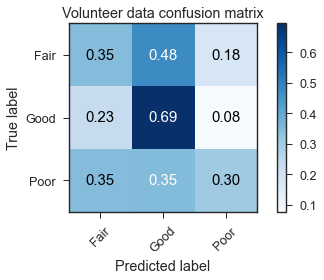

In [11]:
# confusion matrix - normalized
cm = confusion_matrix(y, y_preds)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Volunteer data confusion matrix',
                      cmap=plt.cm.Blues)

## Create a reference dataframe

- Using my model's predictions, I can create a dataframe that professional staff could refer to in order to double-check the health status determined by a volunteer.

In [12]:
# look at a sample of volunteer entries
y.head()

2    Good
3    Good
4    Good
5    Good
6    Good
Name: health, dtype: object

In [13]:
# convert predictions to pandas series
y_preds_series = pd.Series(y_preds, index=y.index)

# look at a sample of model predictions
y_preds_series.head()

2    Fair
3    Good
4    Good
5    Good
6    Good
dtype: object

In [14]:
# build list of indices for trees with differing volunteer entries and model predictions
mismatch_indices = [i for i,v in y.iteritems() if y[i] != y_preds_series[i]]

# number of trees
len(mismatch_indices)

78645

In [15]:
# load original dataframe
trees_initial = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')

In [16]:
# create dataframe of trees with differing differing volunteer entries and model predictions
trees_to_check = trees_initial[trees_initial.index.isin(mismatch_indices)]

# look at the first five rows
trees_to_check.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
7,09/07/2015,208649,103940,POINT (-73.98729652382876 40.7627238542921),9,0,OnCurb,Alive,Good,Tilia americana,...,75,27,MN15,Clinton,1012700,New York,40.762724,-73.987297,9.877691e+05,217157.856088
10,09/05/2015,203719,302371,POINT (-73.91117076849402 40.78242822973097),11,0,OnCurb,Alive,Good,Platanus x acerifolia,...,36,13,QN72,Steinway,4010500,New York,40.782428,-73.911171,1.008850e+06,224349.036588
11,09/05/2015,203726,302371,POINT (-73.91201956608866 40.78173511421239),8,0,OnCurb,Alive,Poor,Platanus x acerifolia,...,36,13,QN72,Steinway,4010500,New York,40.781735,-73.912020,1.008615e+06,224096.273970
14,08/31/2015,192998,211160,POINT (-73.92113023015189 40.664317398984245),30,0,OnCurb,Alive,Fair,Platanus x acerifolia,...,55,20,BK81,Brownsville,3090000,New York,40.664317,-73.921130,1.006131e+06,181314.985517


In [17]:
# confirm number of trees
trees_to_check.shape

(78645, 42)

## Save/Load dataframe of trees to check

In [18]:
# # uncomment to save
# with gzip.open('data/nyc_trees_to_check.pkl', 'wb') as goodbye:
#     pickle.dump(trees_to_check, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/nyc_trees_to_check.pkl', 'rb') as hello:
#     trees_to_check = pickle.load(hello)